In [ ]:
!pip install findspark

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-ccd3aa56-b10b-47df-aef4-ea703da7d8bc/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()

Out[51]: '/databricks/spark'

In [ ]:
#Import Spark Context, SparkSession
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext

In [ ]:
#Import library needed
from datetime import datetime
from pyspark.sql.functions import col, udf, mean, stddev
from pyspark.sql.types import DoubleType, IntegerType, DateType
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
#Start Spark
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

# EDA

In [ ]:
data = spark.read.format("csv").option("header", 'true').option('inferSchema', 'true').load("/FileStore/tables/train.csv")

In [ ]:
#show data
data.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [ ]:
print('Data overview')
data.printSchema()
print('Columns overview')
pd.DataFrame(data.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

Columns overview


,Column Name,Data type
0,PassengerId,int
1,Survived,int
2,Pclass,int
3,Name,string
4,Sex,string
5,Age,double
6,SibSp,int
7,Parch,int
8,Ticket,string
9,Fare,double


In [ ]:
print(f"Data have {data.count()} rows")

Data have 891 rows


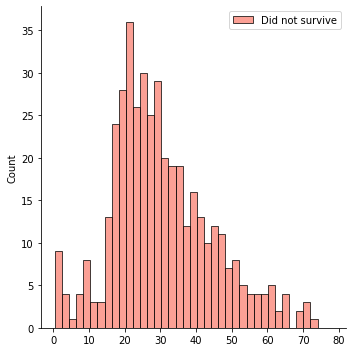

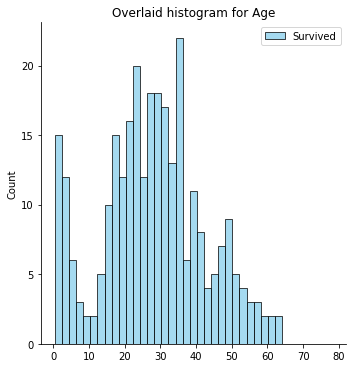

In [ ]:
pd_df = data.toPandas()
for i in ['Age']:
    died = list(pd_df[pd_df['Survived'] == 0][i].dropna())
    survived = list(pd_df[pd_df['Survived'] == 1][i].dropna())
    xmin =min(min(died), min(survived))
    xmax = max(max(died), max(survived))
    width = (xmax -xmin) / 40
    sns.displot(died, color = 'salmon', kde = False, bins= np.arange(xmin, xmax, width), height= 5)
    plt.legend(['Did not survive'])
    
    sns.displot(survived, color = 'skyblue', kde = False, bins = np.arange(xmin, xmax, width), height= 5)
    plt.title('Overlaid histogram for {}'.format(i))
    plt.legend(['Survived'])
    plt.show()

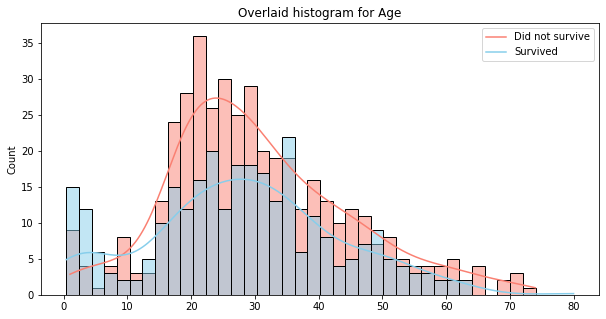

In [ ]:
for i in ['Age']:
    plt.figure(figsize=(10,5))
    sns.histplot(died, color = 'salmon', kde = True, bins= np.arange(xmin, xmax, width))
    sns.histplot(survived, color = 'skyblue', kde = True, bins = np.arange(xmin,xmax, width))
    plt.legend(['Did not survive', 'Survived'])
    plt.title('Overlaid histogram for {}'.format(i))
    plt.show()

In [ ]:
#Check value null
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]
   ).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
#Drop Cabin because this is not help me in this data
data = data.drop("Cabin")

In [ ]:
#Define function for fill mean to null data
def fillna_mean(data, include=set()): 
    means = data.agg(*(
        mean(x).alias(x) for x in data.columns if x in include
    ))
    return data.fillna((means.first().asDict()))

In [ ]:
data = fillna_mean(data, 'Age')

In [ ]:
data.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|   Fare|Embarked|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|   7.25|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|71.2833|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|             26.0|    0|    0|STON/O2. 3101282|  7.925|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|             35.0|    1|    0|          113803|   53.1|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|             35.0|    0|    0|          373450|   8.05|       S|
|          6|       0|  

In [ ]:
df = data.select(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'])
df.printSchema()

columns = ["Age", "Fare", "SibSp", "Parch"]

for col_name in columns:
    # Calculate percentile values
    quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    #Calculate thresholds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    #Filter outliers
    outliers_df = df.filter((col(col_name) < lower_bound) | (col(col_name) > upper_bound))
    print(f"Outlier column {col_name} values:", outliers_df.count())


root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Embarked: string (nullable = true)

Outlier column Age values: 118
Outlier column Fare values: 125
Outlier column SibSp values: 46
Outlier column Parch values: 213


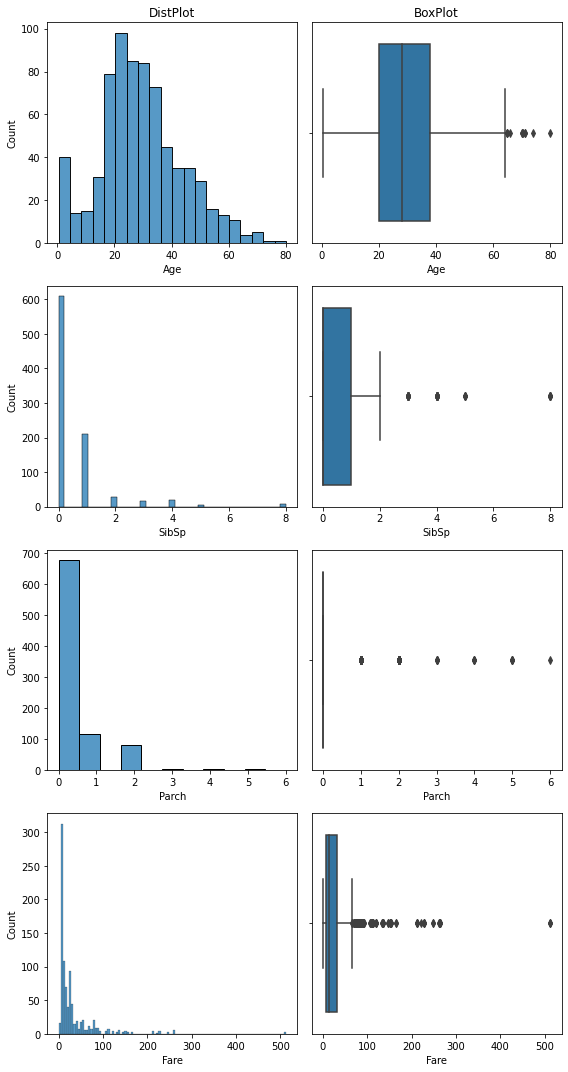

In [ ]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 15))
#Draw boxplot and distplot 
# Age
sns.histplot(pd_df['Age'], ax=axs[0, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(pd_df['Age'], ax=axs[0, 1])
axs[0, 1].set_title("BoxPlot")

# SibSp
sns.histplot(pd_df['SibSp'], ax=axs[1, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(pd_df['SibSp'], ax=axs[1, 1])
axs[0, 1].set_title("BoxPlot")

# Parch
sns.histplot(pd_df['Parch'], ax=axs[2, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(pd_df['Parch'], ax=axs[2, 1])
axs[0, 1].set_title("BoxPlot")

# Fare
sns.histplot(pd_df['Fare'], ax=axs[3, 0])
axs[0, 0].set_title("DistPlot")
sns.boxplot(pd_df['Fare'], ax=axs[3, 1])
axs[0, 1].set_title("BoxPlot")

# Adjust the distance between charts
plt.tight_layout()
plt.show()

In [ ]:
for col_name in columns:
    # Calculate percentile values
    quantiles = data.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    # Calculate thresholds for outliers
    upper_bound = Q3 + 1.5 * IQR

    #Filter out the biggest outliers
    max_outliers_df = data.filter(col(col_name) > upper_bound).orderBy(col_name, ascending=False)

    #Displays the value of the largest outliers
    print(f"Largest outliers for column {col_name}:")
    max_outliers_df.show(5)

Largest outliers for column Age:
+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|  Ticket|   Fare|Embarked|
+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+
|        631|       1|     1|Barkworth, Mr. Al...|male|80.0|    0|    0|   27042|   30.0|       S|
|        852|       0|     3| Svensson, Mr. Johan|male|74.0|    0|    0|  347060|  7.775|       S|
|        494|       0|     1|Artagaveytia, Mr....|male|71.0|    0|    0|PC 17609|49.5042|       C|
|         97|       0|     1|Goldschmidt, Mr. ...|male|71.0|    0|    0|PC 17754|34.6542|       C|
|        117|       0|     3|Connors, Mr. Patrick|male|70.5|    0|    0|  370369|   7.75|       Q|
+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+
only showing top 5 rows

Largest outliers for column Fare:
+-----------+----

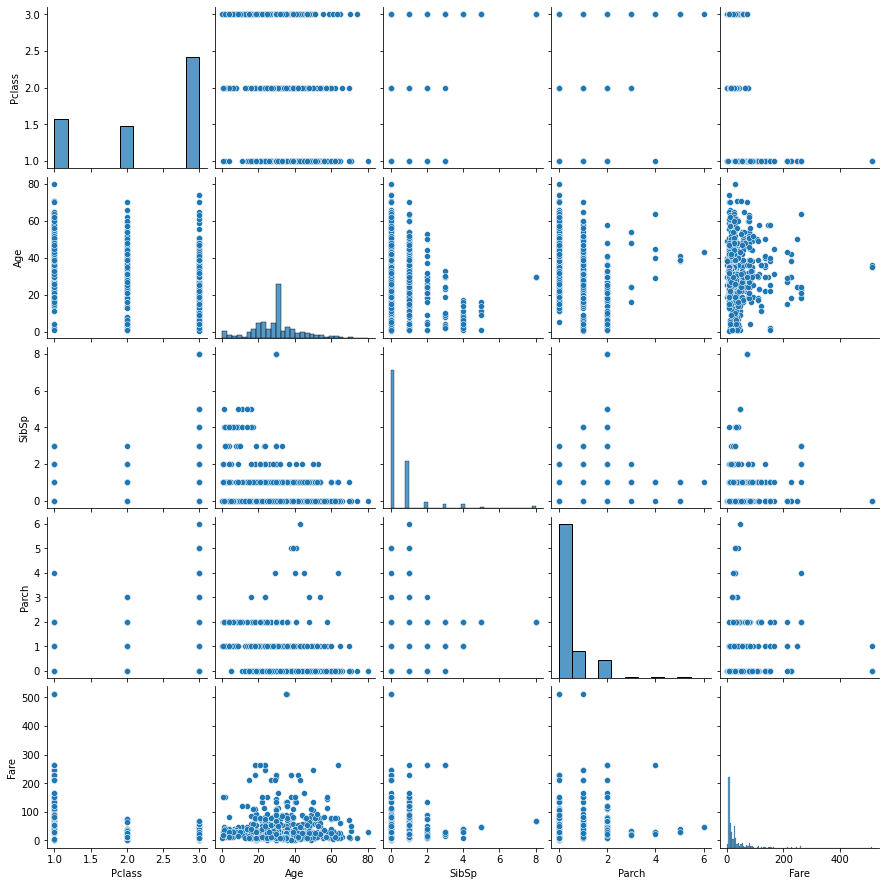

In [ ]:
sns.pairplot(df.drop("Survived").toPandas())
plt.show()

          Survived       Age      Fare     Parch     SibSp    Pclass
Survived  1.000000 -0.077221  0.257307  0.081629 -0.035322 -0.338481
Age      -0.077221  1.000000  0.096067 -0.189119 -0.308247 -0.369226
Fare      0.257307  0.096067  1.000000  0.216225  0.159651 -0.549500
Parch     0.081629 -0.189119  0.216225  1.000000  0.414838  0.018443
SibSp    -0.035322 -0.308247  0.159651  0.414838  1.000000  0.083081
Pclass   -0.338481 -0.369226 -0.549500  0.018443  0.083081  1.000000


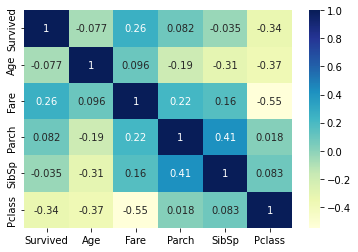

In [ ]:
df_loc = pd_df[['Survived', 'Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
print(df_loc.corr()) 
  
# plotting correlation heatmap 
dataplot = sns.heatmap(df_loc.corr(), cmap="YlGnBu", annot=True) 
  
# displaying heatmap 
plt.show() 

# Data Visualization

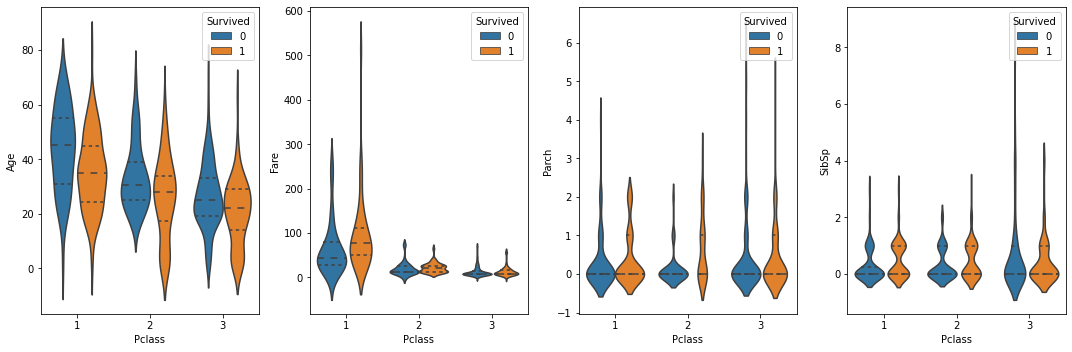

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
features = ['Age', 'Fare', 'Parch', 'SibSp']
for i, feature in enumerate(features):
    sns.violinplot(data=pd_df, y=feature, x='Pclass', hue='Survived', inner='quart', ax=axs[i])
plt.tight_layout()
plt.show()


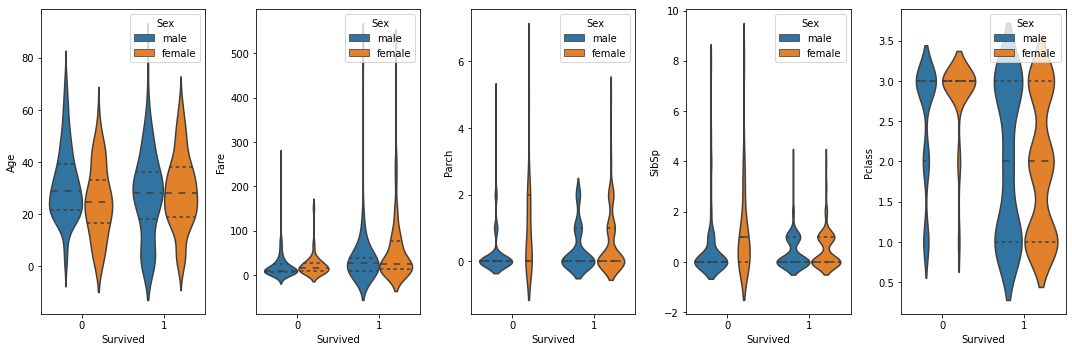

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
features = ['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']
for i, feature in enumerate(features):
    ax = sns.violinplot(data=pd_df, y=feature, x='Survived', hue='Sex', inner='quart', ax=axs[i])
plt.tight_layout()
plt.show()

Total did not Survive: 549  
Total survived: 342

The number of male passengers that survived: 109    
The number of male passengers : 577     
The percentage of male passengers that survived : 0.19%

The number of female passengers that survived: 231  
The number of female passengers : 312   
The percentage of female passengers that survived : 0.74%

In [ ]:
custom_palette = {1: 'skyblue', 0: 'salmon'}
ax = sns.countplot(pd_df, x='Sex', hue = 'Survived', palette = custom_palette)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

ax = axes[0]
sns.countplot(pd_df.loc[pd_df['Pclass'] == 1], x="Survived", ax=ax, palette = custom_palette)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('1st Class')

ax = axes[1]
sns.countplot(pd_df.loc[pd_df['Pclass'] == 2], x="Survived", ax=ax, palette = custom_palette)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('2nd Class')

ax = axes[2]
sns.countplot(pd_df.loc[pd_df['Pclass'] == 3], x="Survived", ax=ax, palette = custom_palette)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('3rd Class')

plt.tight_layout()  
plt.show()

In [ ]:
emb = pd_df[['Survived', 'Embarked']]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))  

ax = axes[0]
sns.countplot(emb.loc[emb['Embarked'] == 'S'], x="Survived", ax=ax, palette = custom_palette)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('S')

ax = axes[1]
sns.countplot(emb.loc[emb['Embarked'] == 'C'], x="Survived", ax=ax, palette = custom_palette)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('C')

ax = axes[2]
sns.countplot(emb.loc[emb['Embarked'] == 'Q'], x="Survived", ax=ax, palette = custom_palette)
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Q')

plt.tight_layout()  

# Build and test Model

In [ ]:
#importing all the required ML packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.tree import DecisionTreeClassifier #Decision Tree 
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import kendalltau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn import metrics


In [ ]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y= None):
        return self


    def transform(self, X) :
        encoder = OneHotEncoder ()
        matrix = encoder.fit_transform(X[['Embarked']]) .toarray ()

        column_names = ["C", "S", "Q", "N"]

        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]

        matrix = encoder.fit_transform(X[['Sex']]) .toarray ()

        column_names = ["Female", "Male"]

        for i in range(len(matrix.T)):
            X[column_names[i]]=matrix.T[i]

        return X

In [ ]:
class FeatureDropper (BaseEstimator, TransformerMixin) :

    def fit(self, X, y=None) :
        return self

    def transform(self, X) :
        return X.drop (["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

In [ ]:
pipeline = Pipeline([
                     ("featureencoder", FeatureEncoder ()),
                     ("featuredropper", FeatureDropper ())])

In [ ]:
df_now = df.toPandas()

In [ ]:
df_now = pipeline.fit_transform(df_now)

In [ ]:
df_now

,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [ ]:
X = df_now.drop(['Survived'], axis = 1)
X.head()

,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,3,22.0,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,26.0,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,1,35.0,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,3,35.0,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [ ]:
y = df_now['Survived']
y.head()

Out[84]: 0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int32

In [ ]:
df_now.columns

Out[85]: Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'S', 'Q',
       'Female', 'Male'],
      dtype='object')

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear')

In [ ]:

from sklearn.utils.validation import column_or_1d

clf.fit(X_train, y_train)

Out[87]: LogisticRegression(solver='liblinear')

In [ ]:
clf.intercept_

Out[88]: array([1.76398714])

In [ ]:
clf.coef_

Out[89]: array([[-0.99746052, -0.02936975, -0.28577171, -0.03870179,  0.00356855,
         0.70244686,  0.69718027,  0.25560322,  2.16736778, -0.40338064]])

In [ ]:
# values same 
print('Score train: ', clf.score(X_train, y_train))
print('Score test: ', clf.score(X_test, y_test))


Score train:  0.8033707865168539
Score test:  0.776536312849162


In [ ]:
yhat_train = clf.predict(X_train)
yhat_test = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuary:", accuracy_score(y_test, yhat_test)*100, "%")

Accuary: 77.6536312849162 %


In [ ]:
def print_scores(y_true,y_pred):
    print(classification_report(y_true,y_pred))

# Confusion Matrix Display and Logistics Regression

I have gained some insights from the EDA part. But with that, i cannot accurately predict or tell whether a passenger will survive or die. So now i will predict the whether the Passenger will survive or not using some great Classification Algorithms.Following are the algorithms I will use to make the model:

1)Logistic Regression

2)Random Forest

3)K-Nearest Neighbours

4)Decision Tree


In [ ]:
#importing all the required ML packages
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [ ]:
X = df_now.iloc[:,1:]
y = df_now.iloc[:,:1]
train,test=train_test_split(df_now, test_size=0.3, random_state=0 ,stratify=df_now['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]

In [ ]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction1,test_Y))

model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction2=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction2,test_Y))

model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction3,test_Y))

model=KNeighborsClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the KNNeighbors is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Logistic Regression is 0.8059701492537313
The accuracy of the Decision Tree is 0.7798507462686567
The accuracy of the Random Forests is 0.8208955223880597
The accuracy of the KNNeighbors is 0.7238805970149254


The accuracy of a model is not the only factor that determines the robustness of the classifier. Let's say that a classifier is trained over a training data and tested over the test data and it scores an accuracy of 90%.

Now this seems to be very good accuracy for a classifier, but can I confirm that it will be 90% for all the new test sets that come over??. The answer is No, because I can't determine which all instances will the classifier will use to train itself. As the training and testing data changes, the accuracy will also change. It may increase or decrease. This is known as model variance. 

To overcome this and get a generalized model, I use <b>Cross Validation</b>.

### Cross Validation¶
Many a times, the data is imbalanced, i.e there may be a high number of class1 instances but less number of other class instances. Thus I should train and test our algorithm on each and every instance of the dataset. Then I can take an average of all the noted accuracies over the dataset.

1)The K-Fold Cross Validation works by first dividing the dataset into k-subsets.

2)Let's say I divide the dataset into (k=5) parts. I reserve 1 part for testing and train the algorithm over the 4 parts.

3)I continue the process by changing the testing part in each iteration and training the algorithm over the other parts. The accuracies and errors are then averaged to get a average accuracy of the algorithm.

This is called K-Fold Cross Validation.

4)An algorithm may underfit over a dataset for some training data and sometimes also overfit the data for other training set. Thus with cross-validation, I can achieve a generalised model.

In [ ]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22, shuffle=True) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Logistic Regression','KNN','Decision Tree','Random Forest']
models=[LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Logistic Regression,0.796929,0.045754
KNN,0.712709,0.033893
Decision Tree,0.780100,0.042752
Random Forest,0.817166,0.052622


### Confusion Matrix¶
It gives the number of correct and incorrect classifications made by the classifier.

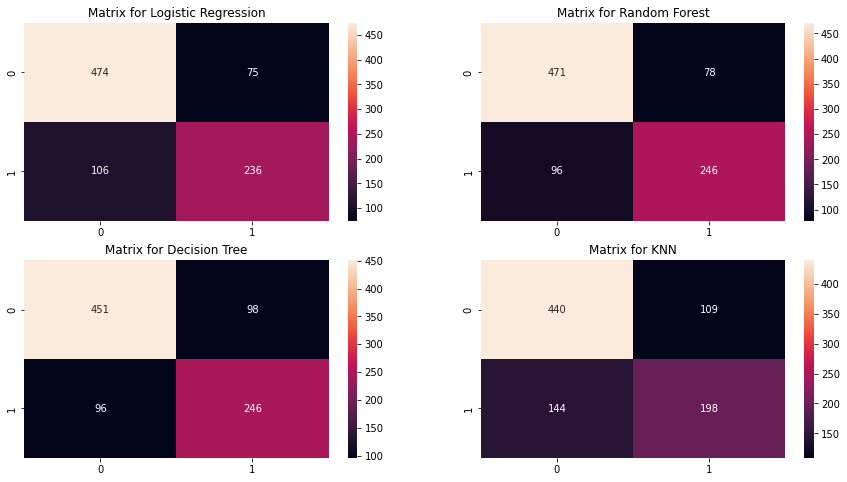

In [ ]:
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction

fig, ax = plt.subplots(2, 2, figsize=(15,8))

y_pred1 = cross_val_predict(LogisticRegression(),X, y,cv=10)
sns.heatmap(confusion_matrix(y, y_pred1), ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for Logistic Regression')

y_pred2 = cross_val_predict(RandomForestClassifier(),X, y,cv=10)
sns.heatmap(confusion_matrix(y, y_pred2), ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Random Forest')

y_pred3 = cross_val_predict(DecisionTreeClassifier(),X, y,cv=10)
sns.heatmap(confusion_matrix(y, y_pred3), ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Decision Tree')

y_pred4 = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X, y, cv=10)
sns.heatmap(confusion_matrix(y, y_pred4),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for KNN')

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

### Interpreting Confusion Matrix 
The left diagonal shows the number of correct predictions made for each class while the right diagonal shows the number of wrong prredictions made. Lets consider the first plot for Logistic Regression:

1)The no.1 of correct predictions are 474(for dead) + 236(for survived) with the mean CV accuracy being (474+236)/891 = 79.6% which I did get earlier.

2)Errors--> Wrongly Classified 75 dead people as survived and 106 survived as dead. Thus it has made more mistakes by predicting dead as survived.

By looking at all the matrices, I can say that Logistic Regression has a higher chance in correctly predicting dead passengers but Random Forest has a higher chance in correctly predicting passengers who survived.

# Make prediction on Test data

In [ ]:
df_test = spark.read.format("csv").option("header", 'true').option('inferSchema', 'true').load("/FileStore/tables/test.csv")

In [ ]:
df_test.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0|          330911| 7.8292| null|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0|          363272|    7.0| null|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0|          240276| 9.6875| null|       Q|
|        895|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0|          315154| 8.6625| null|       S|
|        896|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|         3101298|12.2875| null|       S|
|        897|     3|Svensson, Mr. Joh...|  male|14.0|    0|    0|            7538|  9.225| null|       S|
|        898|     3|Connolly, Miss. Kate|femal

In [ ]:
print('Data overview')
df_test.printSchema()
print('Columns overview')
pd.DataFrame(df_test.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

Columns overview


,Column Name,Data type
0,PassengerId,int
1,Pclass,int
2,Name,string
3,Sex,string
4,Age,double
5,SibSp,int
6,Parch,int
7,Ticket,string
8,Fare,double
9,Cabin,string


In [ ]:
print(f"Data have {df_test.count()} rows")

Data have 418 rows


In [ ]:
#Check value null
from pyspark.sql.functions import col,isnan, when, count
df_test.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_test.columns]
   ).show()

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0| 86|    0|    0|     0|   1|  327|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+



In [ ]:
df_test = fillna_mean(df_test, ['Age', 'Fare'])

In [ ]:
df_test = df_test.drop("Cabin")

In [ ]:
df_test.columns

Out[108]: ['PassengerId',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked']

In [ ]:
df_test_now = df_test.select(['Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Embarked']).toPandas()

In [ ]:
df_test_now.columns

Out[110]: Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Embarked'],
      dtype='object')

In [ ]:
df_test_now = pipeline.fit_transform(df_test_now)

In [ ]:
df_test_now.head()

,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0


In [ ]:
df_test_now.isnull().any()

Out[113]: Pclass    False
Age       False
SibSp     False
Parch     False
Fare      False
C         False
S         False
Q         False
Female    False
Male      False
dtype: bool

In [ ]:
X_test_now = df_test_now
X_test_now.head()

,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0
1,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0
3,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0
4,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0


In [ ]:
Yhat_test_now = clf.predict(X_test_now)

In [ ]:
df_test_now['Survived'] = Yhat_test_now

In [ ]:
df_test_now.head()

,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male,Survived
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,0.0,1.0,0
1,3,47.0,1,0,7.0000,0.0,0.0,1.0,1.0,0.0,0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,0.0,1.0,0
3,3,27.0,0,0,8.6625,0.0,0.0,1.0,0.0,1.0,0
4,3,22.0,1,1,12.2875,0.0,0.0,1.0,1.0,0.0,1


In [ ]:
df_test = df_test.toPandas()

In [ ]:
df_test['Survived'] = Yhat_test_now

In [ ]:
df_test.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1


# Pipeline

In [ ]:
X = df.toPandas().iloc[:,1:]

In [ ]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [ ]:
y = df.toPandas()["Survived"]

In [ ]:
y.head()

Out[124]: 0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int32

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
Input=[('column_tr', make_column_transformer((OneHotEncoder(),
                                            ['Sex', 'Embarked' ]),
                                            remainder='passthrough')),
                                            ('model', LogisticRegression(solver='liblinear'))]

In [ ]:
pipe = Pipeline(Input)

In [ ]:
pipe.fit(X_train, y_train)

Out[128]: Pipeline(steps=[('column_tr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Sex', 'Embarked'])])),
                ('model', LogisticRegression(solver='liblinear'))])

In [ ]:
pipe.predict(X_test)

Out[129]: array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1], dtype=int32)

In [ ]:
pipe.score(X_train, y_train)

Out[130]: 0.8019662921348315

In [ ]:
pipe.score(X_test, y_test)

Out[131]: 0.7932960893854749

In [ ]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
709,3,male,29.699118,1,1,15.2458,C
439,2,male,31.000000,0,0,10.5000,S
840,3,male,20.000000,0,0,7.9250,S
720,2,female,6.000000,0,1,33.0000,S
39,3,female,14.000000,1,0,11.2417,C


In [ ]:
data_pipe = df_test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

In [ ]:
y_new = pipe.predict(data_pipe)

In [ ]:
df_test['Survived_new'] = y_new

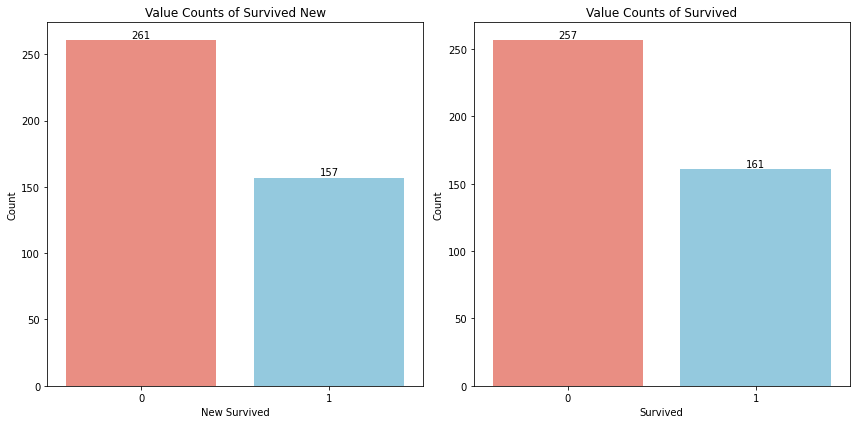

In [ ]:
sur_new_count = df_test['Survived_new'].value_counts()
sur_counts = df_test['Survived'].value_counts()
custom_palette = {1: 'skyblue', 0: 'salmon'}

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

ax= axs[0]
sns.barplot(x=sur_new_count.index, y= sur_new_count.values, ax=axs[0],palette=custom_palette)
for container in ax.containers:
    ax.bar_label(container)
axs[0].set_title('Value Counts of Survived New')
axs[0].set_xlabel('New Survived')
axs[0].set_ylabel('Count')

ax= axs[1]
sns.barplot(x=sur_counts.index, y= sur_counts.values, ax=axs[1], palette=custom_palette)
for container in ax.containers:
    ax.bar_label(container)
axs[1].set_title('Value Counts of Survived')
axs[1].set_xlabel('Survived')
axs[1].set_ylabel('Count')


plt.tight_layout()
plt.show()

In [ ]:
df_test = spark.createDataFrame(df_test)

In [ ]:
df_test.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("/FileStore/tables/test_pred1.csv")